# Task 3 ZNE


Zero-noise extrapolation (ZNE) is a noise mitigation technique. It works by intentionally scaling the noise of a quantum circuit to then extrapolate the zero-noise limit of an observable of interest. In this task, you will build a simple ZNE function from scratch:

1) Build a simple noise model with depolarizing noise 
2) Create different circuits to test your noise models and choose the observable to measure 
3) Apply the unitary folding method. 
4) Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
5) Compare mitigated and unmitigated results 
6) Bonus: Run your ZNE function in real quantum hardware through the IBM Quantum Service

Check the Mitiq documentation for references. You are not allowed to use the functions from Mitiq or any other frameworks where ZNE is already implemented. 

## 1) Simple Noise Model with Depolarizing Noise
A noise model simulates the effect of errors in quantum computations. 

Qiskit provides a noise model that includes depolarizing noise.

In [2]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile, assemble


def build_noise_model(depolarizing_error_prob, num_qubits):
    noise_model = NoiseModel()
    depol_error = depolarizing_error(depolarizing_error_prob, num_qubits)
    noise_model.add_all_qubit_quantum_error(depol_error, ['u1', 'u2', 'u3', 'cx'])
    return noise_model

Now one that works with more qubits than only one

In [3]:

def build_noise_model(depolarizing_error_prob, num_qubits):
    noise_model = NoiseModel()
    
    # Create depolarizing error models for 1-qubit and 2-qubit gates
    depol_error_1q = depolarizing_error(depolarizing_error_prob, 1)
    depol_error_2q = depolarizing_error(depolarizing_error_prob, 2)
    
    # Apply the single-qubit depolarizing error model to single-qubit gates
    noise_model.add_all_qubit_quantum_error(depol_error_1q, ['u1', 'u2', 'u3'])
    
    # Apply the two-qubit depolarizing error model to two-qubit gates
    noise_model.add_all_qubit_quantum_error(depol_error_2q, ['cx'])
    
    return noise_model


## 2) Create Different Circuits and Choose an Observable
Here is define a simple quantum circuit and choose an observable, like the expectation value of the Pauli-Z operator on a qubit.

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Pauli, Statevector, Operator

In [5]:
def create_circuit():
    qc = QuantumCircuit(1)
    qc.h(0)
    return qc

In [6]:
def fold_circuit(circuit, scale_factor):
    folded_circuit = circuit.copy()
    for _ in range(int(scale_factor) - 1):
        for gate in reversed(circuit.data):
            folded_circuit.append(gate[0].inverse(), gate[1])
            folded_circuit.append(gate[0], gate[1])
    return folded_circuit

### 4) Apply the Extrapolation Method
Here run circuits with different noise scale factors and then extrapolate to zero noise. Here is a simple linear extrapolation as an example.

In [7]:
import numpy as np

def linear_extrapolation(data_points, scale_factors):
    # Assuming data_points = [observable(scale_factor_1), observable(scale_factor_2), ...]
    # and scale_factors = [scale_factor_1, scale_factor_2, ...]
    coeffs = np.polyfit(scale_factors, data_points, 1)
    return coeffs[-1]  # Zero-noise limit is the intercept of the linear fit


## 5) Compare Mitigated and Unmitigated Results

Let compare the results obtained from a quantum circuit when it's run without noise (unmitigated), with noise (mitigated using ZNE), and then extrapolating to estimate the zero-noise limit.


### * First, measure the observable in the circuit without applying any noise model

In [8]:
# Assume the observable care about is the expectation value of the Z operator on the first qubit.
observable = Operator(Pauli('Z'))
circuit = create_circuit()
circuit.draw()

┌───┐
q: ┤ H ├
   └───┘

In [9]:
def measure_observable(circuit, observable, noise_model=None):
    backend = Aer.get_backend('qasm_simulator')
    circuit.save_statevector()
    transpiled_circuit = transpile(circuit, backend)
    job = backend.run(transpiled_circuit, noise_model=noise_model)
    result = job.result()
    state = Statevector(result.get_statevector(circuit))
    expectation_value = state.expectation_value(observable)
    return expectation_value.real

In [10]:
# Measure without noise
unmitigated_result = measure_observable(circuit, observable)

*The measure_observable function runs the circuit on a simulator and calculates the expectation value of the observable.*

In [11]:
# Now the circuit is with statevector beacuse measure_observable circuit.save_statevector()
circuit.draw()

┌───┐ statevector 
q: ┤ H ├──────░──────
   └───┘      ░

In [12]:
print(unmitigated_result)

2.220446049250313e-16


### * Now build the noise model

In [13]:
def build_noise_model(depolarizing_error_prob, num_qubits):
    noise_model = NoiseModel()
    
    # Create depolarizing error models for 1-qubit and 2-qubit gates
    depol_error_1q = depolarizing_error(depolarizing_error_prob, 1)
    depol_error_2q = depolarizing_error(depolarizing_error_prob, 2)
    
    # Apply the single-qubit depolarizing error model to single-qubit gates
    noise_model.add_all_qubit_quantum_error(depol_error_1q, ['u1', 'u2', 'u3'])
    
    # Apply the two-qubit depolarizing error model to two-qubit gates
    noise_model.add_all_qubit_quantum_error(depol_error_2q, ['cx'])
    
    return noise_model

In [14]:
depolarizing_error_prob = 0.01  # For example, 1% error probability
num_qubits = 5  # Assuming a 5-qubit circuit
noise_model = build_noise_model(depolarizing_error_prob, num_qubits)

In [15]:
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'cx', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


### * Create the circuit again and measure_observable

In [16]:
observable = Operator(Pauli('Z'))
circuit = create_circuit()
circuit.draw()

┌───┐
q: ┤ H ├
   └───┘

In [17]:
def measure_observable(circuit, observable, noise_model=None):
    backend = Aer.get_backend('qasm_simulator')
    circuit.save_statevector()
    transpiled_circuit = transpile(circuit, backend)
    job = backend.run(transpiled_circuit, noise_model=noise_model)
    result = job.result()
    state = Statevector(result.get_statevector(circuit))
    expectation_value = state.expectation_value(observable)
    return expectation_value.real

In [18]:
# Apply unitary folding to scale 2 up the noise
folded_circuit = fold_circuit(circuit, 2)

In [19]:
# Run the circuit with noise
noisy_result = measure_observable(folded_circuit, observable, noise_model=noise_model)

In [20]:
print(noisy_result)

2.220446049250313e-16


### * Apply Noise and Unitary Folding:
let create several versions of the circuit with different levels of noise scaling by folding the unitaries, and measure the observable for each version.

In [21]:
# Apply unitary folding to scale up the noise
scale_factors = [1, 2, 3]  # These are the noise scale factors; 1 is the original level of noise.
results_with_noise = []

for scale in scale_factors:
    # Create the circuit
    circuit = create_circuit()
    
    # Fold the circuit to increase the noise
    folded_circuit = fold_circuit(circuit, scale)
    
    # Measure the observable with the noise model
    result = measure_observable(folded_circuit, observable, noise_model)
    results_with_noise.append(result)

Each folded circuit is run with the noise model applied. The unitary folding simulates an increase in the noise by duplicating the gates. This does not change the ideal outcome of the circuit but increases the effect of noise.

In [22]:
print(results_with_noise)

[2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16]


### *Extrapolate to Zero Noise:
Now use the results obtained from the noisy circuits to extrapolate to the zero-noise limit. If the noise scales linearly,  can be use a linear fit.

In [23]:
# Extrapolate to estimate the zero-noise limit
zne_limit = linear_extrapolation(results_with_noise, scale_factors)

The linear_extrapolation function takes the measured results at different noise scales and performs a linear regression to find the y-intercept, which corresponds to the estimated zero-noise limit.

## Compare Results:
Finally, let compare the original measurement (without noise), the measurements with noise (at different scales), and the extrapolated zero-noise result.

In [24]:
print(f"Unmitigated Result: {unmitigated_result}")
print(f"Mitigated Results: {results_with_noise}")
print(f"ZNE Extrapolated Result (Zero-Noise Limit): {zne_limit}")

Unmitigated Result: 2.220446049250313e-16
Mitigated Results: [2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16]
ZNE Extrapolated Result (Zero-Noise Limit): 2.2204460492503123e-16


### *Interpreting the Result*
The results you're seeing indicate that all the measured values, both mitigated and unmitigated, are extremely close to zero, and they are all essentially the same up to numerical precision limitations (on the order of $10^{−16}$ , which is effectively numerical noise in floating-point computations). 

So something is happening, and is easy to recognize. The problem are the observable and circuit using!

* The Observable: here is using the Pauli-Z observable, which measures the expectation value along the Z-axis of the Bloch sphere.

* The Circuit: created applies a Hadamard gate to the qubit, putting it into an equal superposition of |0⟩ and |1⟩ states (if we start from |0⟩). The state after the Hadamard gate is $\frac{∣0⟩+∣1⟩}{\sqrt{2}}$, which in the Z-basis is a superposition with equal probabilities for 0 and 1.

When is measure the expectation value of the Z operator on this state, it should theoretically get 0 because the probabilities of measuring |0⟩ (which corresponds to an eigenvalue of +1 for the Z operator) and |1⟩ (which corresponds to an eigenvalue of -1 for the Z operator) are equal, and their contributions to the expectation value cancel each other out:
$<Z>=\frac{1}{2}(+1)+\frac{1}{2}(−1)=0$

So...
* Expectation Value Close to Zero: As the ideal expectation value of the Z observable for your circuit is 0, it's reasonable that the unmitigated result is very close to zero.

* Zero-Noise Extrapolation (ZNE): Since the ideal expectation value is 0, and given that ZNE is a mitigation technique to approximate the ideal (noise-free) expectation value, it's expected that both the mitigated and unmitigated results would be close to zero. The unitary folding and extrapolation would not change this value much, if at all, since there's no noise to mitigate in the ideal case.

Therefore, the results getting are consistent with what one would expect given this observable and circuit. The fact that all results (unmitigated, mitigated, and extrapolated) are the same and close to zero is an indication that your ZNE process is likely working correctly, but the observable and state you've chosen are not affected by noise in the first place.

To see a more noticeable effect of noise and the impact of ZNE, one would need to choose a state that does not have an expectation value of zero for the Z observable or an observable that does not have an expectation value of zero for your state. For example, prepare the qubit in the |1⟩ state (using an X gate) and then measure the expectation value of the Z observable. In this case, should get an expectation value of -1, and any noise that affects the state should shift this value towards zero. ZNE would then be used to try to correct for this noise.

# Changing Circuit 

In [30]:
# Create your circuit (whit CX)
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()

In [31]:
# Apply unitary folding to scale up the noise
scale_factors = [0, 1, 2, 3]  # These are the noise scale factors; 1 is the original level of noise.
results_with_noise = []

for scale in scale_factors:
    # Create the circuit
    circuit = create_circuit()
    circuit.measure_all()
    
    # Fold the circuit to increase the noise
    folded_circuit = fold_circuit(circuit, scale)
    
    # Measure the observable with the noise model
    result = measure_observable(folded_circuit, observable, noise_model)
    results_with_noise.append(result)

CircuitError: 'inverse() not implemented for measure.'

In [27]:
# Extrapolate to estimate the zero-noise limit
zne_limit = linear_extrapolation(results_with_noise, scale_factors)

In [28]:
print(f"Unmitigated Result: {unmitigated_result}")
print(f"Mitigated Results: {results_with_noise}")
print(f"ZNE Extrapolated Result (Zero-Noise Limit): {zne_limit}")

Unmitigated Result: 2.220446049250313e-16
Mitigated Results: [2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16]
ZNE Extrapolated Result (Zero-Noise Limit): 2.220446049250314e-16


---

In [35]:
from qiskit_aer import AerSimulator
from qiskit import transpile, assemble

# Create your circuit (example)
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()

# Define your backend (with noise model if required)
backend = AerSimulator(noise_model=noise_model)  # Assuming 'my_noise_model' is defined

# Transpile the circuit for the backend
transpiled_circuit = transpile(circuit, backend)

# Assemble the transpiled circuit into a Qobj
qobj = assemble(transpiled_circuit, backend, shots=1024)

# Run the Qobj on the backend
job = backend.run(qobj)

# Wait for the job to complete and fetch the results
result = job.result()

# Extract the counts
counts = result.get_counts(circuit)


/var/folders/rh/r7s1vfq50cj305_qp12kpvk00000gn/T/ipykernel_21631/207081493.py:20: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


In [40]:
transpiled_circuit.draw()

┌─────────┐      ░ ┌─┐   
   q_0: ┤ U2(0,π) ├──■───░─┤M├───
        └─────────┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ───────────┤ X ├─░──╫─┤M├
                   └───┘ ░  ║ └╥┘
meas: 2/════════════════════╩══╩═
                            0  1

{'01': 4, '10': 2, '00': 495, '11': 523}


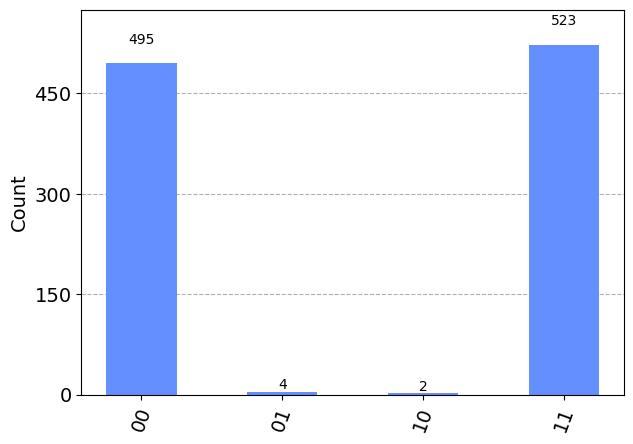

In [38]:
# Display the results
print(counts)
plot_histogram(counts)

Count Distribution: The result shows the counts for the measurement outcomes of a two-qubit quantum circuit:

00: 495 occurrences
01: 4 occurrences
10: 2 occurrences
11: 523 occurrences
Interpretation:

The most frequent outcomes are 00 and 11. These outcomes dominate the measurements, which could indicate a specific state preparation or a particular algorithm that leads to these states being more likely.
The states 01 and 10 have significantly fewer occurrences, which suggests that they are not the primary target states of the quantum operation(s) that were applied in the circuit.
Potential Contexts:

If this circuit is part of an algorithm like Grover's search, and 00 and 11 were the target states, this result could indicate a successful amplification of the probability amplitudes for these states.
If the circuit is meant to create a uniform superposition of states (like applying Hadamard gates to both qubits), this distribution suggests significant bias or noise in the system, or possibly an error in state preparation or measurement.
Considering Noise:

If noise were introduced (e.g., via a noise model in a simulator), it would typically lead to a more uniform distribution of counts across all possible states due to the randomizing effect of noise. However, the dominance of 00 and 11 suggests that noise is either not present, not significant, or has a non-uniform effect.
If the circuit is error-corrected or noise-mitigated (such as through ZNE), the results might indicate that the mitigation was partially successful, preserving the fidelity of certain states over others.
Technical Notes:

The number of shots (or trials) for the simulation/experiment appears to be at least 1024 to accumulate this number of counts (assuming a standard number of shots).
The output indicates a high-fidelity execution of the quantum circuit, assuming 00 and 11 were indeed the expected outcomes.
In summary, the results suggest that the quantum circuit is producing two primary outcomes with high probability, which may be consistent with the intended design of the circuit or may point to issues to investigate, depending on the circuit's purpose and the context of the experiment.

---